In [1]:
%pip install gymnasium
%pip install stable_baselines3


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install keras


Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ba/7c/b971f2485155917ecdcebb210e021e36a6b65457394590be01cc61515310/tensorflow-2.13.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/40/fa/98115f6fe4d92e1962f549917be2dc8e369853b7e404191996fedaaf4dd6/tensorflow_intel-2.13.0-cp310-cp310-win_amd64.whl.metadata
Using cached tensorflow-2.13.0-cp310-cp310-win_amd64.whl (1.9 kB)
Using cached tensorflow_intel-2.13.0-cp310-cp310-win_amd64.whl (276.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\12016\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [10]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [10]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging




In [19]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [12]:
import yfinance as yf
vgt_data = yf.download("VGT", start="2021-01-01", end="2023-04-30")
voo_data = yf.download("VOO", start="2021-01-01", end="2023-04-30")

data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
split_index = int(len(data) * 0.8)
train_df = data[:split_index]
val_df = data[split_index:]

In [14]:
#TRAINING


window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
    'stocks-v0',
    df = train_df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


In [15]:
#VALIDATION

window_size = 10
start_index = window_size
end_index = len(data)

val_env = gym.make(
    'stocks-v0',
    df = val_df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([lambda : train_env, lambda : val_env])

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [24]:
file_handler.close()
logger.removeHandler(file_handler)

file_handler = logging.FileHandler('training.log')
logger.addHandler(file_handler)

In [25]:
logger.info('Initializing the PPO and A2C models...')
ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
a2c_agent = A2C('MlpPolicy', train_env, verbose=1)

logger.info('Training the PPO Agent...')
ppo_agent.learn(total_timesteps=1000)

logger.info('Training the A2C Agent...')
a2c_agent.learn(total_timesteps=1000)

logger.info('Training is complete')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 923      |
|    ep_rew_mean     | 98       |
| time/              |          |
|    fps             | 2288     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1137     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.435   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.000364 |
|    value_loss         | 5.

In [26]:
ppo_rewards = []
obs = val_env.reset()

while True:
    action, _ = ppo_agent.predict(obs)
    logger.info(f'PPO Took action {action} in state {obs}')
    obs, reward, done, info = val_env.step(action)
    ppo_rewards.append(reward)

    if done:
        break

print('PPO average validation reward: ', np.mean(ppo_rewards))



PPO average validation reward:  -0.04412540726597534


In [13]:
a2c_rewards = []
obs = val_env.reset()

while True:
    action, _ = a2c_agent.predict(obs)
    obs, reward, done, info = val_env.step(action)
    a2c_rewards.append(reward)

    if done:
        break

print('PPO average validation reward: ', np.mean(a2c_rewards))


PPO average validation reward:  -0.06354252426079036


In [24]:
if np.mean(ppo_rewards) > np.mean(a2c_rewards):
  agent = ppo_agent
  action, _ = agent.predict(obs)
  print('Agent chosen is: PPO')
else:
  agent = a2c_agent
  action, _ = agent.predict(obs)
  print('Agent chosen is: A2C')




print("info:", info)

Agent chosen is: PPO
info: {'total_reward': -14.16998291015625, 'total_profit': 0.45343864975956477, 'position': 0}


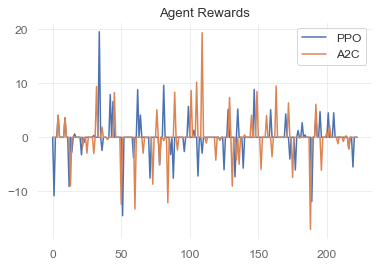

In [28]:
plt.plot(ppo_rewards, label = 'PPO')
plt.plot(a2c_rewards, label = 'A2C')

plt.legend()
plt.title('Agent Rewards')
plt.show()

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


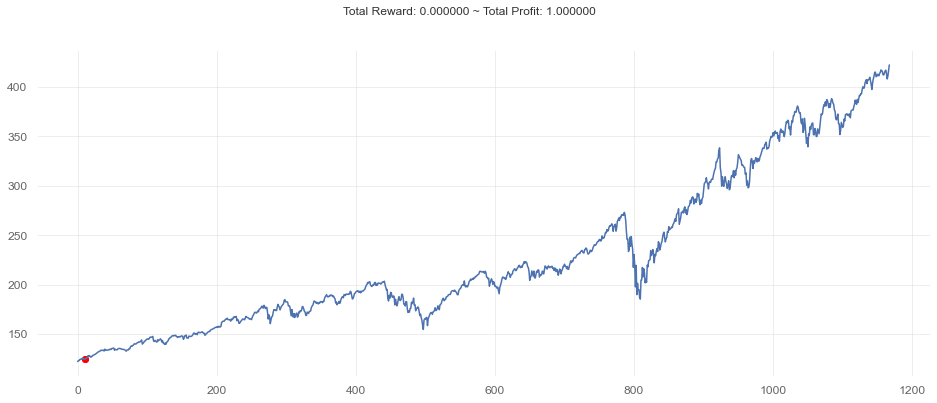

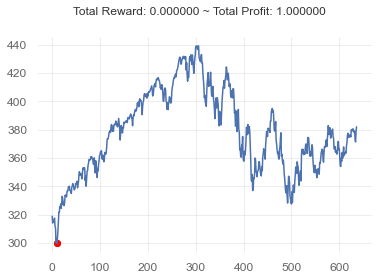

In [63]:
plt.figure(figsize=(16, 6))
for env in envs:
    env.render()
plt.show()

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'